In [2]:
# Import files
import pandas as pd
from datetime import datetime, timedelta
import multiprocessing as mp
from functools import partial
import csv
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import time
import multiprocessing as mp
from functools import partial
import copy
from decimal import Decimal
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from datetime import timedelta, datetime
import timeit
from functools import partial, reduce
from sklearn import preprocessing # normalize the data
import math
from math import ceil

# Machine learning package
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from operator import itemgetter
from itertools import *
from matplotlib.lines import Line2D
import ruptures as rpt
import itertools
import scipy.stats
from scipy.stats import norm

from collections import Counter
import matplotlib.dates as mdates

In [3]:
# (1) Overview of the dataset
file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
list(df.columns)

['VEHICLENUMBER',
 'LONG',
 'LAT',
 'RIDEID',
 'BATTERYPCT',
 'TIMESTAMP',
 'AREAID',
 'EVENT_TYPE',
 'VEHICLETYPE']

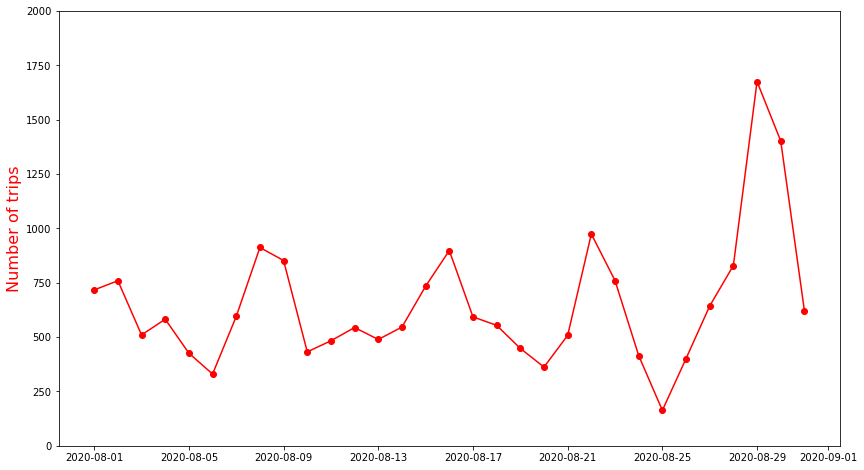

In [6]:
# (2) Trips number per day
import matplotlib.dates as mdates


file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']

df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60

# make threshold
df_trip = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]

df_trip_count = df_trip.groupby(df_trip['TIMESTAMP_x'].dt.date).size().reset_index(name='Count')


# weather
file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df_wea = pd.read_csv(file_loc + 'weather_data.csv')
df_wea['date'] = pd.to_datetime(df_wea['date'])
df_trip_weather = pd.concat([df_trip_count, df_wea], axis=1)
trip_weather = df_trip_weather[['TIMESTAMP_x', 'date', 'Count', 'ave_temp (F)', 'precipitation (inches)']]




fig,ax = plt.subplots(figsize=(14, 8))
# make a plot
ax.plot(trip_weather.date, trip_weather.Count, color="red", marker="o")
# set x-axis label
ax.set_xlabel("",fontsize=14)

# set y-axis label
ax.set_ylabel("Number of trips",color="red",fontsize=16)
ax.set_ylim(0,2000)
plt.show()

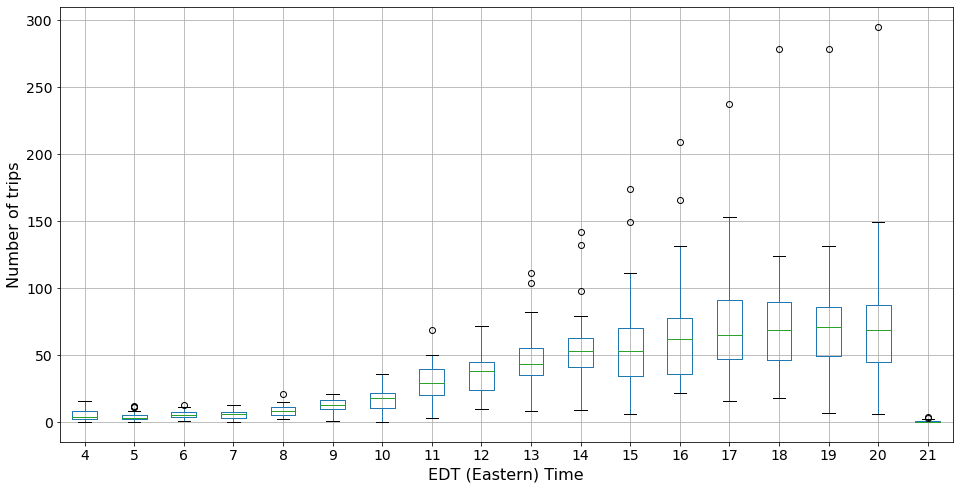

In [8]:
# (3) Distribution of trip bydifferent time period (1-hour interval)
import matplotlib.dates as mdates


file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']


df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60

# make threshold
df_trip = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]


df_trip['Date'] = df_trip['TIMESTAMP_x'].apply(lambda x: str(x).split(" ")[0])
df_trip['Hour'] = df_trip['TIMESTAMP_x'].apply(lambda x: str(x).split(" ")[1].split(":")[0])
trip_date = pd.pivot_table(df_trip, values='RIDEID', index='Date', columns='Hour', aggfunc=len).reset_index()
# a = trip_date.T.reset_index()
# a.rename(columns=a.iloc[0], inplace = True)
# a.drop(a.index[0], inplace = True)

# Chart
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8

a = trip_date.fillna(0)
a.columns = [0, 20, 21, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
b = a[sorted(list(a.columns))]
b.boxplot()
plt.xlabel('EDT (Eastern) Time', size=16)
plt.ylabel('Number of trips', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

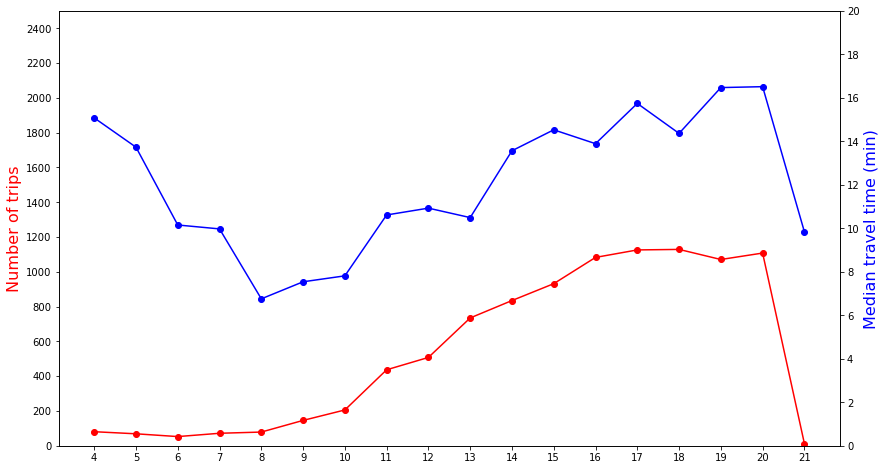

In [11]:
# (4) Relationship between trip number and mdedian travel time per trip

import matplotlib.dates as mdates


file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']


df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60

# make threshold
df_trip = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]

df_trip['Date'] = df_trip['TIMESTAMP_x'].apply(lambda x: str(x).split(" ")[0])
df_trip['Hour'] = df_trip['TIMESTAMP_x'].apply(lambda x: str(x).split(" ")[1].split(":")[0])


# weekend 
weekend = ['2020-08-30', '2020-08-29','2020-08-23', '2020-08-22', '2020-08-16', '2020-08-15','2020-08-01', '2020-08-02', '2020-08-09', '2020-08-08']
df_trip = df_trip[df_trip['Date'].isin(weekend)]

trip_count = df_trip.groupby('Hour').count().reset_index()
trip_count = trip_count[['Hour', 'LONG_x']]
trip_median = df_trip.groupby('Hour')['time difference'].median().reset_index()

count_ave = pd.merge(trip_count, trip_median, on=['Hour'], how='left')
dff = count_ave.T.reset_index()
dff.rename(columns=dff.iloc[0], inplace = True)
dff.drop(dff.index[0], inplace = True)
dff.columns = [0, 20, 21, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
dff = dff[sorted(list(dff.columns))]
dff = dff.T.reset_index()
dff.rename(columns=dff.iloc[0], inplace = True)
dff.drop(dff.index[0], inplace = True)
dff.columns = ['Time', 'Trip_number', 'Median_travel_time']


fig,ax = plt.subplots(figsize=(14, 8))
# make a plot
ax.plot(dff.Time, dff.Trip_number, color="red", marker="o")
# set x-axis label
ax.set_xlabel("",fontsize=14)
ax.set_yticks(np.arange(0, 2600, 200))

# set y-axis label
ax.set_ylabel("Number of trips",color="red",fontsize=16)
ax.set_ylim(0,2500)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dff.Time, dff['Median_travel_time'] ,color="blue",marker="o")
ax2.set_ylabel("Median travel time (min)",color="blue",fontsize=16)
ax2.set_yticks(np.arange(0, 21, 2))
ax2.set_xticks(np.arange(4, 22, 1))

# formatter = mdates.DateFormatter("%m-%d")
# ax.xaxis.set_major_formatter(formatter)
plt.show()

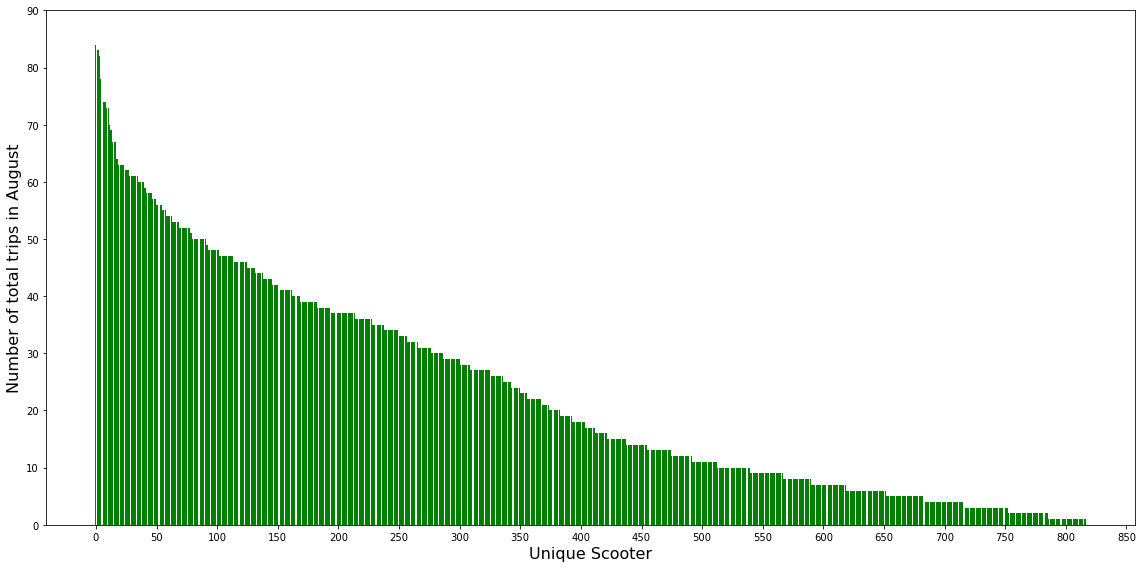

In [15]:
# (5) Demand per unique scooter across a whole month

import matplotlib.dates as mdates


file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']


df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60

# make threshold
df_sc = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]
# df_sc = df_sc[(df_sc['LONG_x'] < - 10) & (df_sc['LAT_x'] < 33.85) & (df_sc['LONG_x'] > -84.45)]
df_sc = df_sc[df_sc['VEHICLETYPE_x'] == 'Scooter']


df_scc = df_sc.groupby('VEHICLENUMBER').count().reset_index()
df_scc = df_scc.iloc[:, :2]
df_scc = df_scc.sort_values('LONG_x', ascending=False)
df_scc = df_scc.reset_index()
df_scc = df_scc.reset_index()
del df_scc['index']

plt.bar(df_scc['level_0'], df_scc['LONG_x'], color='green')
plt.xlabel("Unique Scooter", size =16)
plt.ylabel("Number of total trips in August", size=16)
plt.yticks(np.arange(0, 91, 10))
plt.xticks(np.arange(0, 860, 50))
plt.tight_layout()
plt.show()


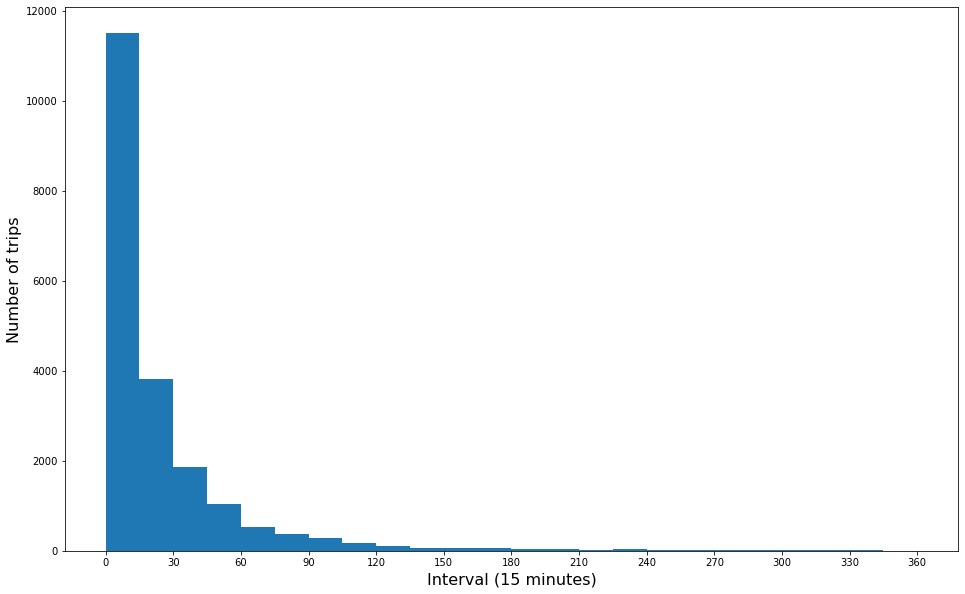

In [41]:
# (6) Distribution of travel time 
file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']

df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60

# Threshold based on the maximum scooter running time
df_trip = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]
# df_trip = df_trip[df_trip['VEHICLETYPE_x'] != 'Cosmo']

plt.hist(df_trip['time difference'], bins = [0,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300,315,330,345,360])
plt.xticks(np.arange(0, 370, 30))
plt.ylabel('Number of trips', size = 16)
plt.xlabel('Interval (15 minutes)', size=16)
plt.show()

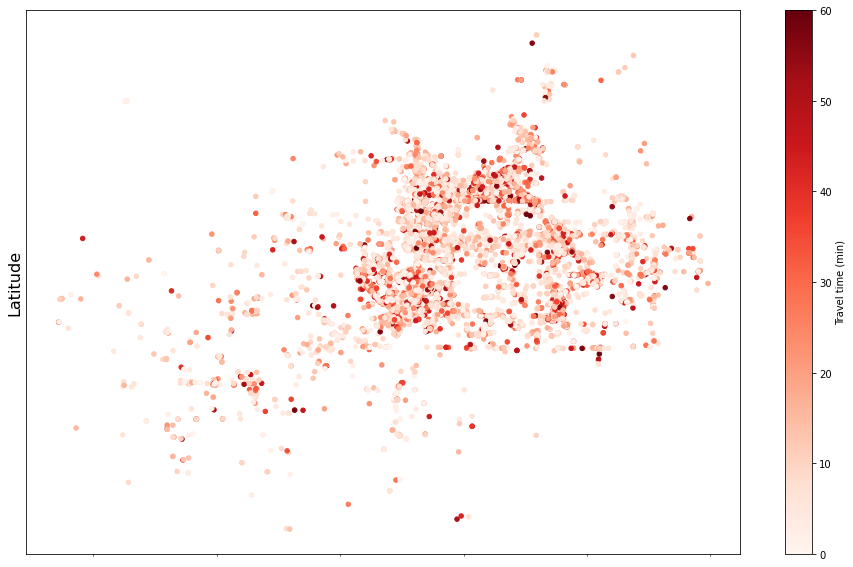

In [42]:
# (7) Pick up location for each trip and corresponding travel time
from matplotlib import rcParams

df_trip1 = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=60)]
df_trip1 = df_trip1[(df_trip1['LONG_x'] < - 10) & (df_trip1['LAT_x'] < 33.85) & (df_trip1['LONG_x'] > -84.45)]
df_trip1.rename(columns = {'time difference':'Travel time (min)'}, inplace = True) 

rcParams['figure.figsize'] = 16, 10
# plt.scatter(df_trip1['LONG_x'], y=df_trip1['LAT_x'], c=df_trip1['time difference'], s=20, cmap='Reds')
df_trip1.plot.scatter(x='LONG_x', y='LAT_x', c='Travel time (min)', vmin=0, vmax=60, colormap='Reds')
plt.xlabel('Longitude', size = 16)
plt.ylabel('Latitude', size = 16)
plt.xticks([]),plt.yticks([])
plt.show()

No handles with labels found to put in legend.


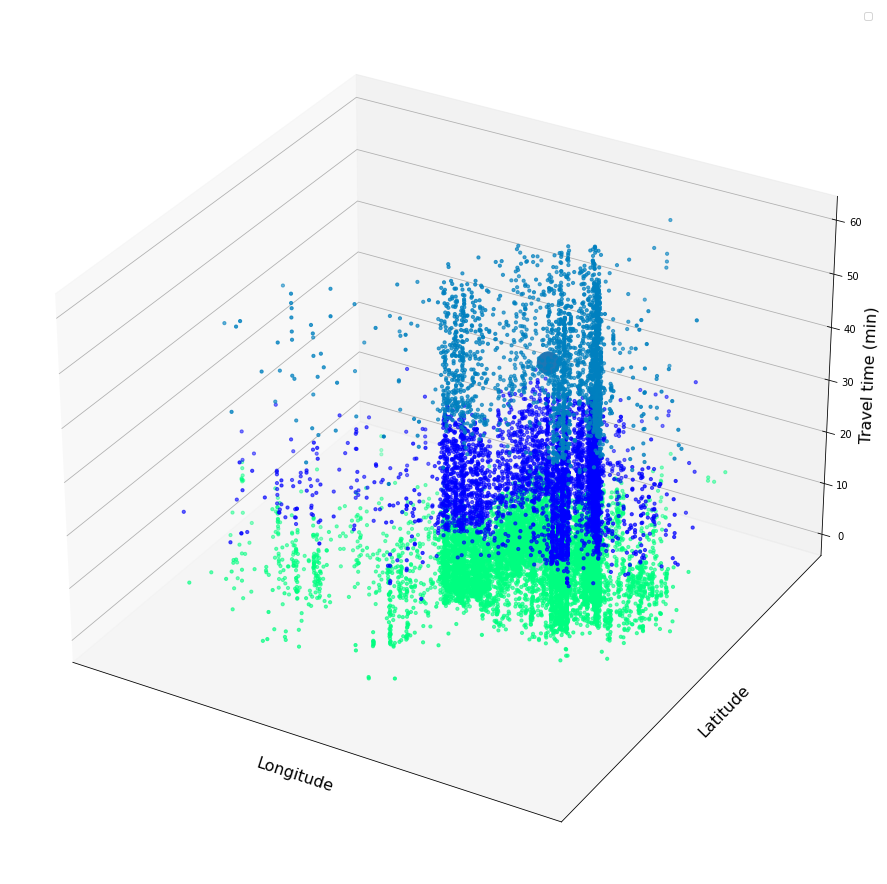

In [29]:
# (8) Using k-means to cluster into 3 groups (3D K-means)
#     Based on pick up location and travel time 

file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']

df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60


# Threshold based on the maximum scooter running time
df_trip = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]

# make threshold
df_trip1 = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=60)]
df_trip1 = df_trip1[(df_trip1['LONG_x'] < - 10) & (df_trip1['LAT_x'] < 33.85) & (df_trip1['LONG_x'] > -84.45)]
df_trip1 = df_trip1[df_trip1['VEHICLETYPE_x'] != 'Cosmo']

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 10
X = df_trip1[['LONG_x', 'LAT_x', 'time difference']]

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
clusts = km.fit_predict(X)
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            km.cluster_centers_[:, 2],
            s = 500)
scatter = ax.scatter(X['LONG_x'],X['LAT_x'],X['time difference'],
                     c=clusts,s=10, cmap='winter')

ax.set_xlabel('Longitude', size = 16)
ax.set_ylabel('Latitude', size = 16)
ax.set_zlabel('Travel time (min)', size = 16)
plt.xticks([]),plt.yticks([])
ax.legend() 
plt.show()

# plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
# plt.xlabel('Longitude', size = 16)
# plt.ylabel('Latitude', size = 16)
# plt.xticks(np.arange(-84.45, -84.33, 0.01))
# plt.yticks(np.arange(33.70, 33.84, 0.01))
# plt.show()

# Reference website
# https://towardsdatascience.com/unsupervised-learning-techniques-using-python-k-means-and-silhouette-score-for-clustering-d6dd1f30b660

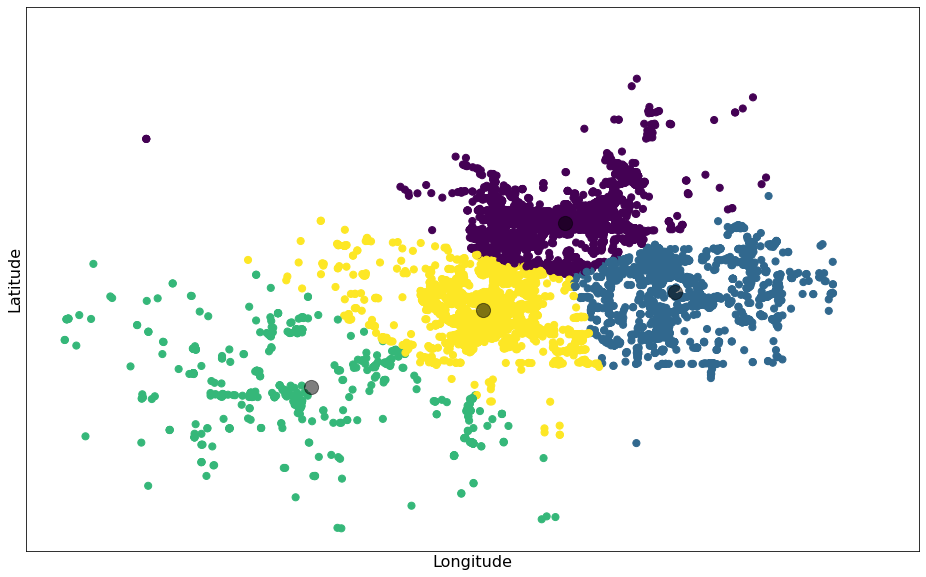

In [32]:
# (9) Using k-means to cluster into 4 groups based on two dimensions (Longtitude and Latitude)

file_loc = 'C:/Users/Tenyu/Desktop/JOB/V/'
df = pd.read_csv(file_loc + 'interview_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
# trip time analysis
df_pickup = df[df['EVENT_TYPE'] == 'USER_PICK_UP']
df_dropoff = df[df['EVENT_TYPE'] == 'USER_DROP_OFF']

df_pickup = df_pickup.reset_index()
df_dropoff = df_dropoff.reset_index()
del df_pickup['index']
del df_dropoff['index']

df_trip = pd.merge(df_pickup, df_dropoff, on = ['VEHICLENUMBER', 'RIDEID'])
df_trip['time difference'] = (df_trip['TIMESTAMP_y'] - df_trip['TIMESTAMP_x']).dt.total_seconds() / 60


# Threshold based on the maximum scooter running time
df_trip = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=360)]

# make threshold
df_trip1 = df_trip[(df_trip['time difference'] > 0) & (df_trip['time difference'] <=60)]
df_trip1 = df_trip1[(df_trip1['LONG_x'] < - 10) & (df_trip1['LAT_x'] < 33.85) & (df_trip1['LONG_x'] > -84.45)]
df_trip1 = df_trip1[df_trip1['VEHICLETYPE_x'] != 'Cosmo']

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 10
X = df_trip1[['LONG_x', 'LAT_x']]


kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Longitude', size = 16)
plt.ylabel('Latitude', size = 16)
plt.xticks(np.arange(-84.45, -84.33, 0.01))
plt.yticks(np.arange(33.70, 33.84, 0.01))
plt.xticks([]),plt.yticks([])

plt.show()

<ipython-input-33-9be4ed6965c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['class'] = list(y_kmeans)


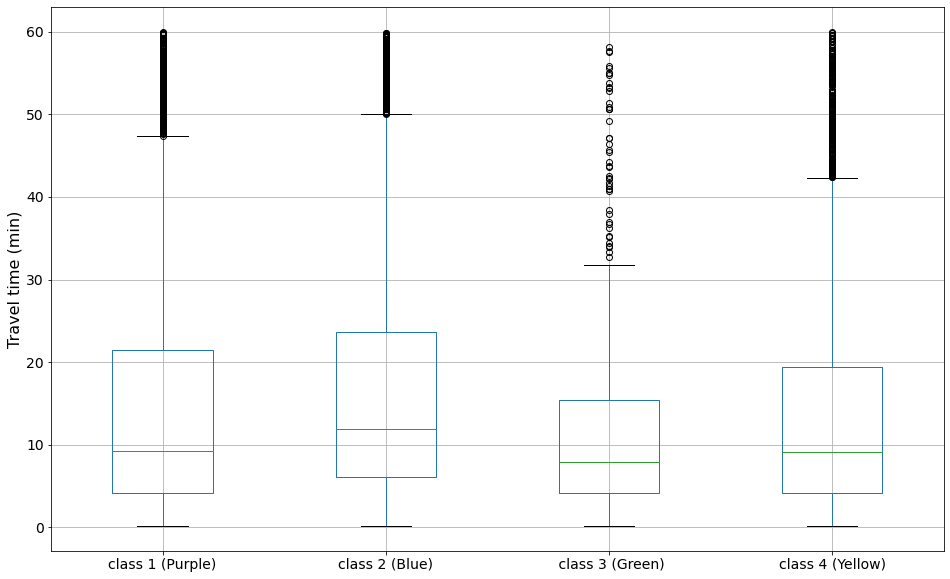

In [33]:
# (10) Travel time distribution based on each cluster

X['class'] = list(y_kmeans)
df_temp = df_trip1.reset_index()
del df_temp['index']
X1 = X.reset_index()
del X1['index']

df_m = pd.concat([X1, df_temp['time difference']], axis=1)
df_m = df_m.reset_index()
k_2 = pd.pivot_table(df_m, values='time difference', index = 'index', columns=['class']).reset_index()
del k_2['index']

k_2.columns = ['class 1 (Purple)', 'class 2 (Blue)', ' class 3 (Green)', 'class 4 (Yellow)']
k_2.boxplot()
# plt.xlabel('Class', size=16)
plt.ylabel('Travel time (min)', size=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()